# Gaussian Distributions in Hyperbolic space
`Drew Wilimitis`

Recent publications have demonstrated how to produce a Gaussian like distribution on hyperbolic space, which is the foundation of probabilistic models. Gaussian Mixture models and Expectation-Maximization (EM) have several advantages over KMeans clustering, such as providing probabilistic or fuzzy classifications and not requiring KMeans assumptions like 'circularity'.   <br>
<br>
I'll first explore the formulation of the pseudo-Gaussian, Wrapped Normal Distribution in the hyperboloid model **[1]**, and then I'll explore another proposal that gives an explicit form of a Gaussian distribution in the Poincaré disk **[2]**. <br>

Finally, I will then attempt to use the hyperbolic gaussian distribution with the Expectation-maximization algorithm to implement a gaussian mixture model in hyperbolic space.

## Load libraries and helper functions

In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import sys
import os

# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils') 
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\hyperbolic_gaussian')
from utils import *
from riemann_mean import *
from distributions import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Method 1: Wrapped Normal Distribution in the Lorentz Model

The wrapped normal distribution presented in **[1]** has the advantage of offering a fully differentiable probability density function, which is highly advantageous for gradient descent algorithms. This contruction might involve complications, however, with its projections and transformations between spaces. 

**Lorentz Model Background & Definitions** <br>

Lorentz model has simpler closed form geodesics and particularly cleaner expressions for the exponential map and parallel transport. <br>

We have the lorentzian product:
$$
\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}=-z_{0} z_{0}^{\prime}+\sum_{i=1}^{n} z_{i} z_{i}^{\prime}
$$ <br>
which we use to define the hyperboloid/Lorentz model as the following set:

$$
\mathbb{H}^{n}=\left\{\boldsymbol{z} \in \mathbb{R}^{n+1}:\langle\boldsymbol{z}, \boldsymbol{z}\rangle_{\mathcal{L}}=-1, \quad z_{0}>0\right\}
$$ <br>

The lorentzian distance is given by: $$
d_{\ell}\left(\boldsymbol{z}, \boldsymbol{z}^{\prime}\right)=\operatorname{arccosh}\left(-\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}\right)
$$ <br>

and finally we set this vector as the origin: 
$$
\boldsymbol{\mu}_{0}=[1,0,0, \ldots .0] \in \mathbb{H}^{n} \subset \mathbb{R}^{n+1}
$$

**Parallel transport** <br>

Parallel transport takes some $v$ to $u$ by mapping between tangent spaces $T_{\nu} \mathbb{H}^{n}$ to $T_{\mu} \mathbb{H}^{n}$ along the geodesic in a parallel manner<br>
<br>

$$
\mathrm{PT}_{\nu \rightarrow \mu}(\boldsymbol{v})=\boldsymbol{v}+\frac{\langle\boldsymbol{\mu}-\alpha \boldsymbol{\nu}, \boldsymbol{v}\rangle_{\mathcal{L}}}{\alpha+1}(\boldsymbol{\nu}+\boldsymbol{\mu})
$$ where $\alpha=-\langle\boldsymbol{v}, \boldsymbol{\mu}\rangle_{\mathcal{L}}$


**Exponential Map** <br>

The exponential map: $\exp _{\mu}: T_{\mu} \mathbb{H}^{n} \rightarrow \mathbb{H}^{n}$  projects some vector $u$ from a tangent space of the hyperboloid to a vector $z \in \mathbb{H}^{n}$
<br>

$$
z=\exp _{\mu}(\boldsymbol{u})=\cosh \left(\|\boldsymbol{u}\|_{L}\right) \boldsymbol{\mu}+\sinh \left(\|\boldsymbol{u}\|_{L}\right) \frac{\boldsymbol{u}}{\|\boldsymbol{u}\|_{\mathcal{L}}}
$$

**Logarithm Map (Inverse Exponential Map)** <br>

The inverse exponential map projects some vector $z$ from the hyperboloid back to the tangent space of the hyperboloid:
<br>

$$\boldsymbol{u}=\exp _{\boldsymbol{\mu}}^{-1}(\boldsymbol{z})=\frac{\operatorname{arccosh}(\alpha)}{\sqrt{\alpha^{2}-1}}(\boldsymbol{z}-\alpha \boldsymbol{\mu})$$ <br>
where $\alpha=-\langle\boldsymbol{\mu}, \boldsymbol{z}\rangle_{\mathcal{L}}$

___
**Algorithm 1:** Sampling from hyperbolic gaussian distribution $\mathcal{G}(\boldsymbol{\mu}, \Sigma)$ with $\mu \in \mathbb{H}^{n}$ and positive definite $\Sigma .$
___ 

1. Sample a vector ${\boldsymbol{v}^{*}}$ from the Gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{\Sigma}) \text { defined over } \mathbb{R}^{n}$
2. Interpret ${\boldsymbol{v}^{*}}$ as an element of $T_{\boldsymbol{\mu}_{0}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$ by rewriting
$ {\boldsymbol{v}^{*}} \text { as } \boldsymbol{v}=[0, {\boldsymbol{v}^{*}}]$<br>

3. Parallel transport the vector $\boldsymbol{v} \ $  to  $\ \boldsymbol{u} \in T_{\boldsymbol{\mu}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$
along the geodesic from $\mu_{0}$ to $\mu$ <br>

4. Map $u$ to $\mathbb{H}^{n}$ by $\exp _{\mu}$

___

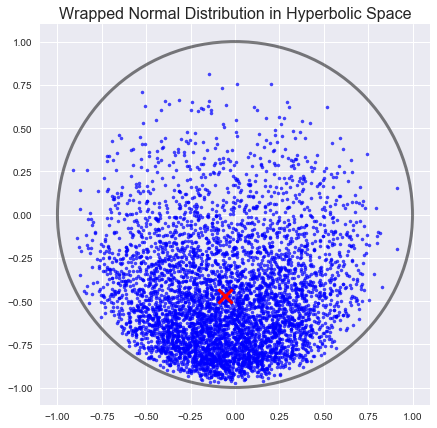

In [8]:
# draw n samples from wrapped normal distribution and map to poincare ball
n = 5000
test_mean = poincare_pt_to_hyperboloid(generate_data(1, radius=0.7)[0], metric='minkowski')
test_cov = np.eye(2)
gaussian_samples = hyperboloid_pts_to_poincare(hyperbolic_sampling(n, test_mean, test_cov**2), metric='minkowski')

# plot samples from wrapped normal distribution in poincare ball
plt.figure(figsize=(7,7))
plt.style.use('seaborn')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], c='blue', s=10, alpha=0.7)
plt.scatter(hyperboloid_pt_to_poincare(test_mean, metric='minkowski')[0], hyperboloid_pt_to_poincare(test_mean, metric='minkowski')[1],
            s=200, c='red', edgecolor='black', marker='x', linewidth=3)
plt.title('Wrapped Normal Distribution in Hyperbolic Space', size=16)
plt.show();

___
**Algorithm 2:** Calculate log-pdf
___

$\text { Input: sample } \boldsymbol{z} \in \mathbb{H}^{n}, \text { parameter } \boldsymbol{\mu} \in \mathbb{H}^{n}, \Sigma$ <br>
$\text { Output: } \log p(\boldsymbol{z})$<br>
$\text { Require: } \boldsymbol{\mu}_{0}=(1,0, \cdots, 0)^{\top} \in \mathbb{H}^{n} $<br>
1. $\text { Map } \boldsymbol{z} \text { to } \boldsymbol{u}=\exp _{\boldsymbol{\mu}}^{-1}(\boldsymbol{z}) \in T_{\boldsymbol{\mu}} \mathbb{H}^{n} $<br>
2. $\text { Move } \boldsymbol{u} \text { to } \boldsymbol{v}=\mathrm{P} \mathrm{T}_{\boldsymbol{\mu}_{0} \rightarrow \boldsymbol{\mu}}^{-1}(\boldsymbol{u}) \in T_{\boldsymbol{\mu}_{0}} \mathbb{H}^{n} $<br>
3. $\text { Calculate } \log p(\boldsymbol{z})$

$$\log p(\boldsymbol{z})=\log p(\boldsymbol{v})-\log \operatorname{det}\left(\frac{\partial \operatorname{proj}_{\boldsymbol{\mu}}(\boldsymbol{v})}{\partial \boldsymbol{v}}\right)$$<br>

$$\operatorname{det}\left(\frac{\partial \operatorname{proj}_{\mu}(\boldsymbol{v})}{\partial \boldsymbol{v}}\right)=\left(\frac{\sinh r}{r}\right)^{n-1}$$
with $r=\|\boldsymbol{u}\|_{\mathcal{L}}$

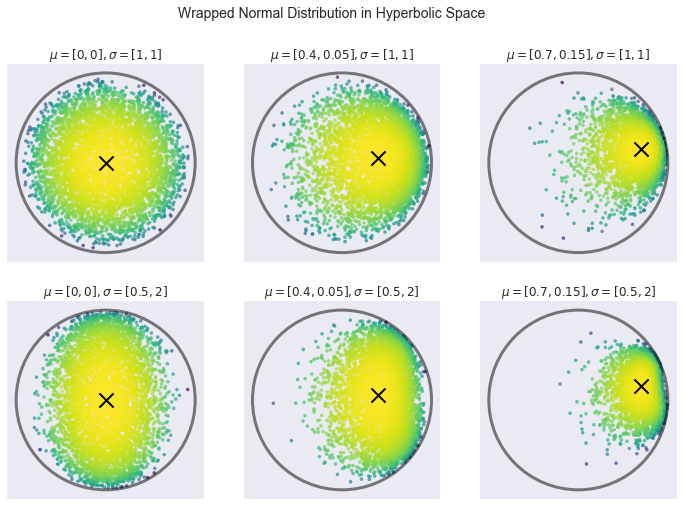

In [9]:
# set parameters
n = 5000
test_means = [[0, 0], [0.4, 0.05], [0.7, 0.15]]
test_sigmas = [[1, 1], [0.5, 2]]

# plot log pdf for each pair of parameters
fig, axs = plt.subplots(2,3, figsize=(12, 8))
axs = axs.ravel()
for i in range(6):
    test_mu = poincare_pt_to_hyperboloid(test_means[i%3], metric='minkowski')
    test_sigma = np.diag(test_sigmas[int(i/3)])
    gaussian_samples = hyperbolic_sampling(n, test_mu, test_sigma)
    Z = np.array([log_pdf(z, mu=test_mu, sigma=test_sigma) for z in gaussian_samples])
    gaussian_samples = hyperboloid_pts_to_poincare(gaussian_samples, metric='minkowski')
    ax = axs[i]
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    ax.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], c=Z, s=10, alpha=0.7, cmap='viridis')
    ax.scatter(hyperboloid_pt_to_poincare(test_mu, metric='minkowski')[0], hyperboloid_pt_to_poincare(test_mu, metric='minkowski')[1],
                s=200, c='black', edgecolor='black', marker='x', linewidth=2)
    ax.set_title('$\mu = {}, \sigma = {}$'.format(str(test_means[i%3]), str(test_sigmas[int(i/3)])));

plt.suptitle('Wrapped Normal Distribution in Hyperbolic Space', size=14)
plt.savefig('images/hyperbolic_gaussian_pdf')
plt.show();

## Method 2: Explicitly defined Gaussian in the Poincare Disk

A closed form expression for the gaussian density is highly advantageous, however, this density is not fully differentiable and might make it significantly harder to sample from this gaussian density in hyperbolic space.

$$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\sigma})=\frac{1}{Z(\boldsymbol{\sigma})} e^{-\frac{d^{2}(\boldsymbol{x}, \boldsymbol{\mu})}{2 \sigma^{2}}} \quad Z(\boldsymbol{\sigma})=2 \pi \sqrt{\frac{\pi}{2}} \boldsymbol{\sigma} e^{\frac{\sigma^{2}}{2}} \operatorname{erf}\left(\frac{\boldsymbol{\sigma}}{\sqrt{2}}\right)
$$ <br>
Error function term given by: $$
\begin{aligned}
\operatorname{erf}(x) &=\frac{1}{\sqrt{\pi}} \int_{-x}^{x} e^{-t^{2}} d t \\
&=\frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}} d t
\end{aligned}
$$

The density is somewhat similar to the Euclidean case, but here the distance $d(\boldsymbol{x}, \boldsymbol{\mu})$ becomes the Poincaré distance, and the parameters are the Frechet mean $\boldsymbol{\mu}$, and the dispersion $\sigma > 0$.

In [4]:
def uniform_sample_hyperboloid_disc(max_distance, centre=None):
    """
    Return a sample drawn uniformly at random from the disc of
    radius `max_distance` on the hyperboloid.
    NOTE: formula is specific to the case of local-dimension 2.
    """
    rank = 2
    tangent = np.random.randn(rank + 1)
    tangent[rank] = 0
    tangent /= np.sqrt(tangent.dot(tangent))
    # we use inversion sampling: invert the CDF, apply result to uniform random samples from [0,1]
    p = np.random.uniform()
    tangent *= np.arccosh(1 + p * (np.cosh(max_distance) - 1))
    basept = coordinate_vector(rank, rank + 1)
    if centre is None:
        centre = basept
    else:
        centre_log = logarithm(basept, centre)
        tangent = geodesic_parallel_transport(basept, centre_log, tangent)
    return exponential(centre, tangent)

## Standard EM Algorithm with Gaussian Mixture Models

**Input**: Training data  $x_1, \ldots , x_n\in \mathbb{R}^{d}$ and specified number of source components/gaussian clusters $k$:<br>

**Goal**: Perform clustering on input data and return cluster assignments <br>
1. **Initialization step**: Initialize gaussian mean, covariance $(\mu_k , \Sigma_k)$ for each gaussian cluster $\mathcal{G}(\boldsymbol{\mu_k}, \Sigma_k)$ and initialize cluster assignments<br>
2. **E-step**: For each data point $x_i$, and for each cluster label $k$, compute probability $p\left(y_{i}=k | x_{i}, \Theta^{(t)}\right)$ of class assignment <br>
3. **M-step**: Update parameters $\Theta^{(t+1)}$ by computing new means and covariances based on updated class assignment probabilities <br>
4. **Repeat steps 2-3 until stopping criteria** <br>
5. **Return:** cluster labels for all $x_i$ and final parametrized gaussian cluster $\mathcal{G_k}(\boldsymbol{\mu_k}, \Sigma_k)$ for all $k$

### Expectation Step: Assign likelihoods given parameters

For each data point $x_i$, and for each cluster $k$, compute likelihood of the data point given the cluster assignment $k$ with parameters $(\mu_k, \Sigma_k) $, and we then call this $w_{ik}$. We ensure the sum is equal to 1 for a given data point. $w_{i 1}+w_{i 2}+\ldots+w_{i K}=1$<br>
<br>
and we have each probability that $x_i$ drawn from k-th cluster as: <br>

$$w_{i k}=\frac{\pi_{k} N\left(x_{i} | \mu_{k}, \Sigma_{k}\right)}{\sum_{k=1}^{K} \pi_{k} N\left(x_{i} | \mu_{k}, \Sigma_{k}\right)}$$ <br>
where $\pi_k$ is the cluster weight computed below and we divide by the normalization term

### Maximization Step: Update parameters given likelihoods

First we compute soft counts $N_{k}^{\mathrm{soft}}=w_{1 k}+w_{2 k}+\ldots+w_{N k}=\sum_{i=1}^{N} w_{i k}$, which we use to update cluster weights: $\hat{\pi}_{k}=\frac{N_{k}^{\mathrm{soft}}}{N}$

Then we need to update the mean by estimating the Riemannian barycenter:<br>

$$\hat{\mu}_{k}=\arg \min _{\mu} \sum_{i=1}^{N} w_{i k} d^{2}\left(\mu, x_{i}\right)$$ <br>

Finally we update standard deviation by solving the optimization problem:<br>

$$\hat{\sigma_{k}}=\underset{\sigma_{s}}{\operatorname{argmin}}\left|\left(\frac{1}{\sum_{i=0}^{N} w_{i k}} \sum_{i=0}^{N} d^{2}\left(\mu_{k}, x_{i}\right) w_{i k}\right)-\Phi^{-1}\left(\sigma_{s}\right)\right|$$ <br>

where $\Phi: \mathbb{R}_{+} \longrightarrow \mathbb{R}_{+}$, given by the inverse of $\sigma \mapsto \sigma^{3} \times \frac{d}{d \sigma} \log \zeta_{m}(\sigma)$<br>

and we have the following forms for zeta:<br>

$$\zeta_{m}(\mu, \sigma)=\zeta_{m}(0, \sigma)=\zeta_{m}(\sigma)=\int_{\mathbb{B}^{m}} \exp \left[-\frac{d^{2}(x, 0)}{2 \sigma^{2}}\right] d v(x)$$<br>
<br>
$$\zeta_{m}(\sigma)=\sqrt{\frac{\pi}{2}} \frac{\sigma}{2^{m-1}} \sum_{k=0}^{m-1}(-1)^{k} C_{m-1}^{k} e^{\frac{p_{k}^{2} \sigma^{2}}{2}}\left(1+\operatorname{erf}\left(\frac{p_{k} \sigma}{\sqrt{2}}\right)\right)$$

In [11]:
class HyperbolicGMM():
    """
    Gaussian Mixture Model in hyperbolic space where we use the Wrapped Normal Distribution
    and its p.d.f to determine likelihood of cluster assignments. Applies gradient descent in
    the hyperboloid model to iteratively compute the Riemannian barycenter.
    
    Note: Follows the Expectation-Maximization (EM) approach for Unsupervised Clustering
    """
    
    def __init__(self,n_clusters=3,max_iter=300,tol=1e-5,verbose=False):
        """ Initialize Gaussian Mixture Model and set training parameters """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.labels = None
        
    def init_gaussians(self, radius=0.35):
        """ Randomly sample starting points (centers) around small uniform ball """
        theta = np.random.uniform(0, 2*np.pi, self.n_clusters)
        u = np.random.uniform(0, radius, self.n_clusters)
        r = np.sqrt(u)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        centers = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
        self.means = poincare_pts_to_hyperboloid(centers, metric='minkowski')
        self.variances = np.tile([1, 1], self.n_clusters).reshape((self.n_clusters, 2))
        
    #------------------------------------------------------------------------------
    #------------------------ EXPECTATION STEP ------------------------------------
    #------------------------------------------------------------------------------
        
    def normalization_term(self, xi, eps=1e-5):
        """ Sum all weighted likelihood assignments for normalization """
        total = 0
        K = len(self.cluster_weights)
        for i in range(K):
            total += self.cluster_weights[i]*np.exp(log_pdf(z=xi, mu=self.means[i], sigma=self.variances[i]))
        if abs(total) < eps:
            return eps
        else:
            return total

    def update_likelihoods(self, X):
        """ Compute likelihoods using log-pdf of Wrapped Normal Distribution """
        N = X.shape[0]
        K = self.n_clusters
        W = np.zeros((K, N))
        for j in range(K):
            for i in range(N):
                W[j, i] = self.cluster_weights[j] * np.exp(log_pdf(z=X[i], mu=self.means[j], sigma=self.variances[j]))
                W[j, i] = W[j, i] / self.normalization_term(X[i])
        self.likelihoods = W
                
    #-----------------------------------------------------------------------------
    #------------------------ MAXIMIZATION STEP ----------------------------------
    #-----------------------------------------------------------------------------
    
    def update_cluster_weights(self):
        """ Update new cluster weights based on cluster assignment likelihoods """
        # W: matrix with weights w_1k, ..., w_Nk - shape K x N
        K = self.likelihoods.shape[0]
        N = self.likelihoods.shape[1]
        updated_weights = np.array([np.sum(self.likelihoods[i, :])/N for i in range(K)])
        self.cluster_weights = updated_weights
        
    def update_means(self, X, num_rounds=10, alpha=0.3, tol=1e-4):
        """ Apply weighted barycenter algorithm to update gaussian clusters """
        for i in range(self.n_clusters):
            self.means[i] = weighted_barycenter(self.means[i], X, self.likelihoods[i, :])
            
    #-----------------------------------------------------------------------------
    #------------------------ TRAINING ROUTINE -----------------------------------
    #-----------------------------------------------------------------------------
    
    def loss_fn(self, X):
        """ Wrapper for auxilliary function to compute total barycenter loss """
        loss = 0
        for i in range(self.n_clusters):
            distances = np.array([hyperboloid_dist(self.means[i], x)**2 for x in X])
            weighted_distances = self.likelihoods[i, :] * distances
            loss += np.sum(weighted_distances)
        self.loss = loss
            
    def fit(self, X, y=None, max_epochs=60, verbose=False, metrics=False):
        """
        Fit K gaussian distributed clusters to data, return cluster assignments by max likelihood 
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y: optionally train a supervised model with given labels y (in progress)
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        
        # make sure X within poincaré ball
        #if (norm(X, axis=1) > 1).any():
        #    X = X / (np.max(norm(X, axis=1)))
        
        if metrics:
            self.metrics = []
        
        # initialize random gaussian centroids
        self.n_samples = X.shape[0]
        self.init_gaussians()
        
        # set cluster weights equally
        self.cluster_weights = np.repeat(1/self.n_samples, self.n_clusters)
        
        # initialize assignments as the most likely cluster for each xi
        self.assignments = np.zeros((self.n_samples, self.n_clusters))
        
        # loop through the expectation and maximization steps
        for j in range(max_epochs):

            # update likelihoods given new parameters
            self.update_likelihoods(X)

            # update parameters given likelihoods
            self.update_cluster_weights()
            self.update_means(X)
            self.metrics.append(self.means)
            
            for i in range(self.n_samples):
                # zero out current cluster assignment
                self.assignments[i, :] = np.zeros((1, self.n_clusters))
                # find centroid that gives maximum likelihood
                k_max = np.argmax(self.likelihoods[:, i])
                self.assignments[i, k_max] = 1
            if verbose:
                self.loss_fn(X)
                print('---- Epoch ' + str(j) + ' complete ---- Loss: ' + str(self.loss))
        self.labels = np.argmax(self.likelihoods, axis=1)
        self.loss_fn(X)
        return

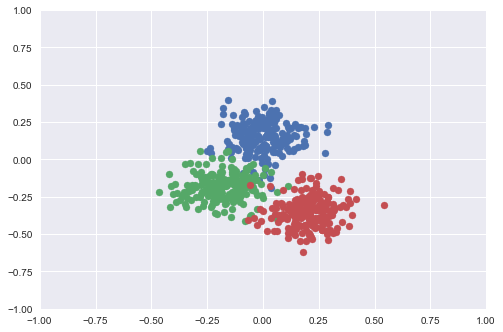

In [16]:
x1 = np.random.normal(loc=0, scale=0.1, size=(200, 2)) + np.array([0, 0.15])
x2 = np.random.normal(loc=-0.35, scale=0.2, size=(200, 2))/2
x3 = np.random.normal(loc=0, scale=0.1, size=(200, 2)) + np.array([0.2, -0.35])
X = np.vstack((x1, x2, x3))
X = X / np.max(norm(X, axis=1)) - 0.05
plt.scatter(x1[:, 0], x1[:, 1]);
plt.scatter(x2[:, 0], x2[:, 1]);
plt.scatter(x3[:, 0], x3[:, 1]);
plt.xlim(-1,1)
plt.ylim(-1,1);

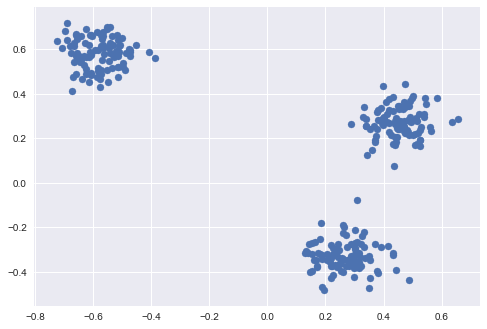

In [18]:
from sklearn.datasets import make_blobs
X, y = make_blobs(300)
X = X / np.max(norm(X, axis=1)) - 0.05
plt.scatter(X[:, 0], X[:, 1]);

In [19]:
gmm = HyperbolicGMM(n_clusters=3)
X = np.array([proj(x) for x in X])
X_hyp = poincare_pts_to_hyperboloid(X, metric='minkowski')
gmm.fit(X_hyp, metrics=True)

In [20]:
np.sum(gmm.assignments, axis=0)
np.array([hyperboloid_pts_to_poincare(x, metric='minkowski') for x in gmm.metrics])

array([  0.,   0., 300.])

array([[[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-0.4078559 ,  0.22164544],
        [ 0.45782479,  0.31097001],
        [-0.28961097,  0.1685971 ]],

       [[-

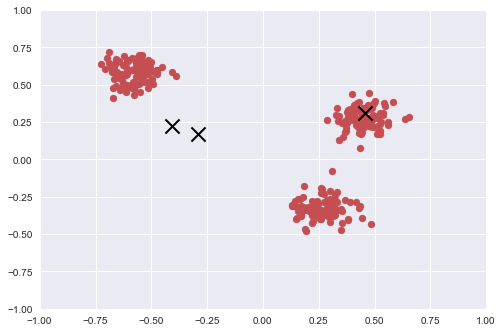

In [21]:
plt.scatter(X[np.argmax(gmm.assignments, axis=1) == 0, 0], X[np.argmax(gmm.assignments, axis=1) == 0, 1])
plt.scatter(X[np.argmax(gmm.assignments, axis=1) == 1, 0], X[np.argmax(gmm.assignments, axis=1) == 1, 1])
plt.scatter(X[np.argmax(gmm.assignments, axis=1) == 2, 0], X[np.argmax(gmm.assignments, axis=1) == 2, 1])
X_p = hyperboloid_pts_to_poincare(gmm.means, metric='minkowski')
plt.scatter(X_p[:, 0], X_p[:, 1], s=200, marker='x', c='black', linewidth=2);
plt.ylim([-1,1])
plt.xlim([-1,1]);

## References
___

**[1]** Nagano, Y., Yamaguchi, S., Fujita, Y., & Koyama, M. (2019). A Differentiable Gaussian-like Distribution on Hyperbolic Space for Gradient-Based Learning. ArXiv, abs/1902.02992. <br>

**[2]** Ovinnikov, Ivan. “Poincaré Wasserstein Autoencoder.” ArXiv abs/1901.01427 (2019): n. pag.